Episode 1, Reward: -263.11421966552734
Episode 2, Reward: -233.11421966552734
Episode 3, Reward: -160.11421966552734
Episode 4, Reward: -133.11421966552734
Episode 5, Reward: -10.941956043243408
Episode 6, Reward: -165.98602610826492
Episode 7, Reward: -309.11421966552734
Episode 8, Reward: -285.11421966552734
Episode 9, Reward: -154.11421966552734
Episode 10, Reward: -212.11421966552734
Episode 11, Reward: -97.11421966552734
Episode 12, Reward: -202.11421966552734
Episode 13, Reward: -304.11421966552734
Episode 14, Reward: -82.98602610826492
Episode 15, Reward: -143.11421966552734
Episode 16, Reward: -175.11421966552734
Episode 17, Reward: -122.11421966552734
Episode 18, Reward: -100.0
Episode 19, Reward: -90.11421966552734
Episode 20, Reward: 33.885780334472656
Episode 21, Reward: -290.9860261082649
Episode 22, Reward: -163.11421966552734
Episode 23, Reward: -230.11421966552734
Episode 24, Reward: -201.11421966552734
Episode 25, Reward: -168.11421966552734
Episode 26, Reward: -79.114

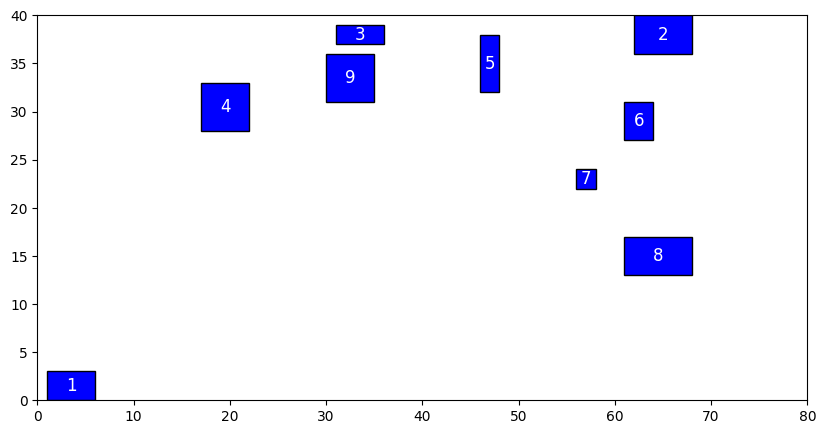

[(1, 0), (62, 36), (31, 37), (17, 28), (46, 32), (61, 27), (56, 22), (61, 13), (30, 31)]


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

# Define rectangle dimensions (width, height)
rectangles = [
    (5, 3), (6, 4), (5, 2), (5, 5), (2, 6), (3, 4), (2, 2), (7, 4), (5, 5)
]

# Bin dimensions
bin_width = 80
bin_height = 40

# Constraints for proximity
proximity_constraints = [
    (2, 3), (2, 4), (2, 8),  # Rectangle 3 close to 4, 5, and 9
    (6, 5), (6, 1)  # Rectangle 7 close to 6 and 2
]

# Graph Neural Network model for encoding relationships between rectangles
class GNN(nn.Module):
    """
    Graph Neural Network (GNN) for encoding relationships between rectangles.
    This model uses two graph convolutional layers to process node features and edge relationships.
    Attributes:
        conv1 (GCNConv): The first graph convolutional layer.
        conv2 (GCNConv): The second graph convolutional layer.
    """

    def __init__(self, input_dim, hidden_dim, output_dim):
        """
        Initialize the GNN model with input, hidden, and output dimensions.
        Args:
            input_dim (int): The dimensionality of the input features.
            hidden_dim (int): The dimensionality of the hidden layer.
            output_dim (int): The dimensionality of the output features.
        """
        super(GNN, self).__init__()
        self.conv1 = torch_geometric.nn.GCNConv(input_dim, hidden_dim)
        self.conv2 = torch_geometric.nn.GCNConv(hidden_dim, output_dim)
    
    def forward(self, data):
        """
        Perform a forward pass through the GNN model.
        Args:
            data (torch_geometric.data.Data): The graph data containing node features (x) and edge indices (edge_index).
        Returns:
            torch.Tensor: The output node features after processing through the GNN.
        """
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Reinforcement Learning agent
class RLAgent:
    """
    Reinforcement Learning agent for optimizing rectangle placements.
    Attributes:
        gnn (torch.nn.Module): Graph Neural Network model for state encoding.
        optimizer (torch.optim.Optimizer): Optimizer for training the GNN.
        best_reward (float): Best reward achieved so far.
        best_placements (list): Placements corresponding to the best reward.
        exploration_penalty (float): Penalty applied to encourage exploration.
    """

    def __init__(self, gnn):
        """
        Initialize the RL agent.
        Args:
            gnn (torch.nn.Module): Graph Neural Network model for encoding states.
        """
        self.gnn = gnn
        self.optimizer = optim.Adam(self.gnn.parameters(), lr=0.01)
        self.best_reward = float('-inf')  # Initialize with a very low value
        self.best_placements = None  # To store the best placements
        self.exploration_penalty = 0.025  # Small penalty to discourage random exploration once we find good solutions

    def get_action(self, state):
        """
        Predict actions for a given state using the GNN.
        Args:
            state (torch_geometric.data.Data): Encoded graph state.
        Returns:
            torch.Tensor: Predicted actions for the rectangles.
        """
        # Predict action from state using GNN
        return self.gnn(state)
    
    def update(self, state, reward, placements):
        """
        Update the GNN model based on reward and placements.
        Args:
            state (torch_geometric.data.Data): Current graph state.
            reward (float): Reward achieved for the current placements.
            placements (list): Current placements of rectangles.
        """
        # Track the best reward and corresponding placements
        if reward > self.best_reward:
            self.best_reward = reward  # Update best reward if current reward is higher
            self.best_placements = placements  # Store the best placements
        
        # Apply penalty to encourage finding better solutions and refining the best found ones
        if reward == self.best_reward:
            reward -= self.exploration_penalty  # Penalty for exploration around best solution (discourage randomness)
        
        # Convert reward to a tensor for backpropagation
        reward_tensor = torch.tensor([reward], dtype=torch.float32, requires_grad=True)
        
        # We want to maximize the reward, so negate the reward to treat it as a loss
        loss = -reward_tensor  # Negative reward for maximization
        self.optimizer.zero_grad()
        loss.backward()  # Compute gradients
        self.optimizer.step()  # Update model parameters

# Function to encode state of the bin (rectangles, positions, constraints)
def encode_state(rectangles, bin_width, bin_height, proximity_constraints):
    """
    Encode the state of the bin into a graph representation.
    Args:
        rectangles (list): List of rectangle dimensions as (width, height).
        bin_width (int): Width of the bin.
        bin_height (int): Height of the bin.
        proximity_constraints (list): List of pairs of rectangles that must be close.
    Returns:
        Data: A `torch_geometric.data.Data` object containing node features and edge indices.
    """
    num_rectangles = len(rectangles)
    
    # Node features (width, height, and proximity)
    node_features = torch.tensor([[w, h] for w, h in rectangles], dtype=torch.float)
    
    # Edge index (pairs of rectangles that are close to each other)
    edge_index = []
    for (i, j) in proximity_constraints:
        edge_index.append([i, j])
        edge_index.append([j, i])
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    
    return Data(x=node_features, edge_index=edge_index)

# Function to check if two rectangles overlap, considering 1-unit separation
def is_overlap(rect1, rect2, x1, y1, x2, y2):
    """
    Check if two rectangles overlap, considering a 1-unit separation.

    :param rect1: A tuple representing the width and height of the first rectangle.
    :param rect2: A tuple representing the width and height of the second rectangle.
    :param x1: The x-coordinate of the bottom-left corner of the first rectangle.
    :param y1: The y-coordinate of the bottom-left corner of the first rectangle.
    :param x2: The x-coordinate of the bottom-left corner of the second rectangle.
    :param y2: The y-coordinate of the bottom-left corner of the second rectangle.

    :return: True if the rectangles overlap, False otherwise.
    """
    w1, h1 = rect1
    w2, h2 = rect2
    
    # Adding 1-unit separation to the overlap condition
    return not (x1 + w1 + 1 <= x2 or x1 >= x2 + w2 + 1 or y1 + h1 + 1 <= y2 or y1 >= y2 + h2 + 1)

# Function to place the rectangles based on GNN-guided reinforcement learning
def place_rectangles(rectangles, bin_width, bin_height, proximity_constraints, num_episodes=100):
    """
    Place rectangles in a bin using reinforcement learning with a Graph Neural Network (GNN) agent.

    :param rectangles: A list of tuples representing the dimensions (width, height) of the rectangles.
    :param bin_width: The width of the bin.
    :param bin_height: The height of the bin.
    :param proximity_constraints: Constraints for maintaining minimum separation between rectangles.
    :param num_episodes: The number of episodes for training the agent (default is 100).

    :return: The best placements of rectangles corresponding to the highest reward found by the agent.
    """
    # Initialize GNN and agent
    input_dim = 2  # width and height
    hidden_dim = 16
    output_dim = 2  # x, y position
    gnn = GNN(input_dim, hidden_dim, output_dim)
    agent = RLAgent(gnn)
    
    placements = []
    
    for episode in range(num_episodes):
        # Encode the current state of the bin
        state = encode_state(rectangles, bin_width, bin_height, proximity_constraints)
        
        # Get action (placement for each rectangle)
        predicted_placements = agent.get_action(state).detach().numpy()  # Ensure it's a NumPy array
        
        # Try to place the rectangles one by one
        valid_placements = []
        
        # Place Rectangle 1 on top of the bin (y=0)
        rect1_x = random.randint(0, bin_width - rectangles[0][0])
        valid_placements.append((rect1_x, 0))
        
        # Place Rectangle 2 on the bottom of the bin (y=bin_height - height of rectangle 2)
        rect2_x = random.randint(0, bin_width - rectangles[1][0])
        valid_placements.append((rect2_x, bin_height - rectangles[1][1]))
        
        # Place the remaining rectangles
        for i, (x, y) in enumerate(predicted_placements):
            if i not in [0, 1]:  # Skip the first two rectangles
                # Try to place the rectangle at (x, y)
                if 0 <= x <= bin_width - rectangles[i][0] and 0 <= y <= bin_height - rectangles[i][1]:
                    # Check for overlap with previously placed rectangles
                    overlap = False
                    for (px, py) in valid_placements:
                        if is_overlap(rectangles[i], rectangles[i], px, py, x, y):
                            overlap = True
                            break
                    
                    if not overlap:
                        valid_placements.append((x, y))
                    else:
                        # If overlap, try again with different coordinates (for simplicity, random adjustment here)
                        found_valid_position = False
                        while not found_valid_position:
                            x_new = random.randint(0, bin_width - rectangles[i][0])
                            y_new = random.randint(0, bin_height - rectangles[i][1])
                            overlap = False
                            for (px, py) in valid_placements:
                                if is_overlap(rectangles[i], rectangles[i], px, py, x_new, y_new):
                                    overlap = True
                                    break
                            if not overlap:
                                valid_placements.append((x_new, y_new))
                                found_valid_position = True
                else:
                    # If outside bin, try again with different coordinates
                    found_valid_position = False
                    while not found_valid_position:
                        x_new = random.randint(0, bin_width - rectangles[i][0])
                        y_new = random.randint(0, bin_height - rectangles[i][1])
                        if 0 <= x_new <= bin_width - rectangles[i][0] and 0 <= y_new <= bin_height - rectangles[i][1]:
                            overlap = False
                            for (px, py) in valid_placements:
                                if is_overlap(rectangles[i], rectangles[i], px, py, x_new, y_new):
                                    overlap = True
                                    break
                            if not overlap:
                                valid_placements.append((x_new, y_new))
                                found_valid_position = True
        
        placements = valid_placements
        reward = calculate_reward(placements, bin_width, bin_height, proximity_constraints, rectangles)
        agent.update(state, reward, placements)

        print(f"Episode {episode+1}, Reward: {reward}")
    
    return agent.best_placements  # Return the best placements corresponding to the best reward

# Function to calculate the reward for a given placement
def calculate_reward(placements, bin_width, bin_height, proximity_constraints, rectangles):
    """
    Calculate the reward for a given placement of rectangles in a bin.

    :param placements: A list of tuples representing the (x, y) positions of the placed rectangles.
    :param bin_width: The width of the bin.
    :param bin_height: The height of the bin.
    :param proximity_constraints: A list of tuple pairs specifying which rectangles should be close to each other.
    :param rectangles: A list of tuples representing the dimensions (width, height) of the rectangles.

    :return: The calculated reward based on the placement, area coverage, and proximity penalties.
    """
    reward = 0
    
    # Calculate area covered (subtract empty space)
    for (x, y) in placements:
        if not 0 <= x <= bin_width and 0 <= y <= bin_height:
            reward -= 100  # Simple area reward (each valid placement increases reward)
    
    # Add proximity penalties based on constraints
    for (i, j) in proximity_constraints:
        x1, y1 = placements[i]
        x2, y2 = placements[j]
        
        # Compute the closest corners between two rectangles
        w1, h1 = rectangles[i]
        w2, h2 = rectangles[j]
        
        # Corners of both rectangles
        corners_i = [(x1, y1), (x1 + w1, y1), (x1, y1 + h1), (x1 + w1, y1 + h1)]
        corners_j = [(x2, y2), (x2 + w2, y2), (x2, y2 + h2), (x2 + w2, y2 + h2)]
        
        min_distance = float('inf')  # Initialize to a large number
        
        # Find the closest corners
        for corner_i in corners_i:
            for corner_j in corners_j:
                dist = abs(corner_i[0] - corner_j[0]) + abs(corner_i[1] - corner_j[1])
                min_distance = min(min_distance, dist)
        
        # Apply a penalty if the minimum distance is greater than 10
        if min_distance < 25:
            reward += 50  # Penalize for not being close enough

        # Manhattan distance between centers of rectangles i and j
        center1_x, center1_y = x1 + w1 / 2, y1 + h1 / 2
        center2_x, center2_y = x2 + w2 / 2, y2 + h2 / 2
        
        # Manhattan distance between the centers
        manhattan_distance = abs(center1_x - center2_x) + abs(center1_y - center2_y)
        
        # Reward for reducing Manhattan distance (the smaller, the better)
        reward -= manhattan_distance  # This will reduce the reward if the distance is large

    return reward


# Plot the final bin with placements and annotate each rectangle
def plot_bin(bin_width, bin_height, rectangles, placements):
    """
    Plot the bin with rectangle placements and annotate each rectangle.

    :param bin_width: The width of the bin.
    :param bin_height: The height of the bin.
    :param rectangles: A list of tuples representing the dimensions (width, height) of the rectangles.
    :param placements: A list of tuples representing the (x, y) positions of the placed rectangles.

    :return: None. Displays the plot of the bin with annotated rectangle placements.
    """
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.set_xlim(0, bin_width)
    ax.set_ylim(0, bin_height)

    for i, rect in enumerate(rectangles):
        x, y = placements[i]  # No need to detach; already in NumPy format
        if x is not None and y is not None:
            ax.add_patch(plt.Rectangle((x, y), rect[0], rect[1], edgecolor='black', facecolor='blue', fill=True))
            ax.text(x + rect[0]/2, y + rect[1]/2, str(i+1), color='white', ha='center', va='center', fontsize=12)

    ax.set_aspect('equal', adjustable='box')  # Square aspect ratio
    plt.show()

# Main function
if __name__ == "__main__":
    """
    Main function to run RL-based rectangle placement and plot the best result.

    This function runs the rectangle placement optimization using reinforcement learning (RL),
    then plots the best placements of the rectangles inside the bin with annotations.

    :returns: None
    """
    # Run RL-based rectangle placement
    best_placements = place_rectangles(rectangles, bin_width, bin_height, proximity_constraints, num_episodes=2500)
    
    # Plot the best result with annotations
    plot_bin(bin_width, bin_height, rectangles, best_placements)
    print(best_placements)
